# Исследование сервиса аренды самокатов GoFast

Имеем данные о некоторых пользователях из нескольких городов, а также об их поездках. 

**Задача:** проанализировать данные и проверить гипотезы, которые могут помочь бизнесу вырасти:

- Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

- Гипотеза 2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.

- Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
1. без подписки
- абонентская плата отсутствует;
- стоимость одной минуты поездки — 8 рублей;
- стоимость старта (начала поездки) — 50 рублей;
2. с подпиской Ultra
- абонентская плата — 199 рублей в месяц;
- стоимость одной минуты поездки — 6 рублей;
- стоимость старта — бесплатно.

### Загрузка данных, изучение информации.

Импортируем библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import binom, norm
from math import factorial
from math import sqrt

Загружаем файлы с данными и сохраняем их в переменные:

- users - данные о пользователях;
- rides - данные о поездках;
- subscriptions - данные о подписках.

In [2]:
users = pd.read_csv('https://code.s3.yandex.net/datasets/users_go.csv')
rides = pd.read_csv('https://code.s3.yandex.net/datasets/rides_go.csv')
subscriptions = pd.read_csv('https://code.s3.yandex.net/datasets/subscriptions_go.csv')

display('Данные о пользователях', users.head())

'Данные о пользователях'

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


где:

- user_id - уникальный идентификатор пользователя;
- name - имя пользователя;
- age - возраст;
- city - город;
- subscription_type - тип подписки (free, ultra).

In [3]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [4]:
display('Данные о поездках', rides.head())

'Данные о поездках'

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


где:

- user_id - уникальный идентификатор пользователя;
- distance - расстояние, которое пользователь проехал в текущей сессии (в метрах);
- duration - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
- date - дата совершения поездки.

In [5]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [6]:
display('Данные о подписках', subscriptions.head())

'Данные о подписках'

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


где:

- subscription_type - тип подписки;
- minute_price - стоимость одной минуты поездки по данной подписке;
- start_ride_price - стоимость начала поездки;
- subscription_fee - стоимость ежемесячного платежа.

In [7]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


**Вывод:** при изучении информации о датафреймах, было выявлено несоответствие типа данных: датафрейм с информацией о поездках - дата совершения поездки - тип данных object, который на этапе предобработки данных будет изменен на datetime.

### Предобработка данных.

#### Проверка корректной записи названий столбцов

In [8]:
users.columns.unique() # Данные о пользователях

Index(['user_id', 'name', 'age', 'city', 'subscription_type'], dtype='object')

In [9]:
rides.columns.unique() # Данные о поездках

Index(['user_id', 'distance', 'duration', 'date'], dtype='object')

In [10]:
subscriptions.columns.unique() # Данные о подписках

Index(['subscription_type', 'minute_price', 'start_ride_price',
       'subscription_fee'],
      dtype='object')

**Вывод:** все названия столбцов записаны корректно.

#### Проверка наличия дубликатов

In [11]:
users.duplicated().sum() # Данные о пользователях

31

In [12]:
rides.duplicated().sum() # Данные о поездках

0

In [13]:
subscriptions.duplicated().sum() # Данные о подписках

0

В датафрейме с данными о пользователях обнаружены явные дубликаты. Удаляем их и заменяем старые индексы на новые: 

In [14]:
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

0

Дубликаты удалены.

**Вывод:** явные дубликаты были обнаружены в датафрейме 'users' (данные о пользователях) - удалены.

#### Проверка наличия пропущенных значений

In [15]:
users.isna().sum() # Данные о пользователях

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [16]:
rides.isna().sum() # Данные о поездках

user_id     0
distance    0
duration    0
date        0
dtype: int64

In [17]:
subscriptions.isna().sum() # Данные о подписках

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

**Вывод:** пропусков не выявлено.

#### Изменение типов данных

На этапе изучения данных было обнаружено несоответствие типа данных в датафрейме с информацией о поездках (rides): дата совершения поездки (столбец date) - тип данных object нужно изменить на datetime:

In [18]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%dT%H:%M:%S')
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


**Вывод:** Тип данных в столбце 'date' датафрейма rides изменен с object на datetime.

#### Создание новых колонок

Создаем новый столбец с номером месяца в датафрейме с информацией о поездках (rides) с названием 'month', где 1 - январь, 2 - февраль и тд.:

In [19]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


**Вывод:** В датафрейм rides добавлен столбец 'month' с номером месяца (1 - январь, 2 - февраль и тд.).

#### Общий вывод

**При выполнении предобработки данных проведены:**

1. **Проверка корректной записи названий столбцов.** Ошибок не выявлено.

2. **Проверка наличия дубликатов.** Явные дубликаты были обнаружены в датафрейме 'users' (данные о пользователях) - удалены.

3. **Проверка наличия пропущенных значений.** Пропусков не выявлено.

4. **Изменение типов данных.** Тип данных в столбце 'date' датафрейма rides изменен с object на datetime.

5. **Создание новых колонок.** В датафрейм rides добавлен столбец 'month' с номером месяца (1 - январь, 2 - февраль и тд.).

### Исследовательский анализ данных

#### Частота встречаемости городов

In [20]:
users['city'].value_counts()

Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: city, dtype: int64

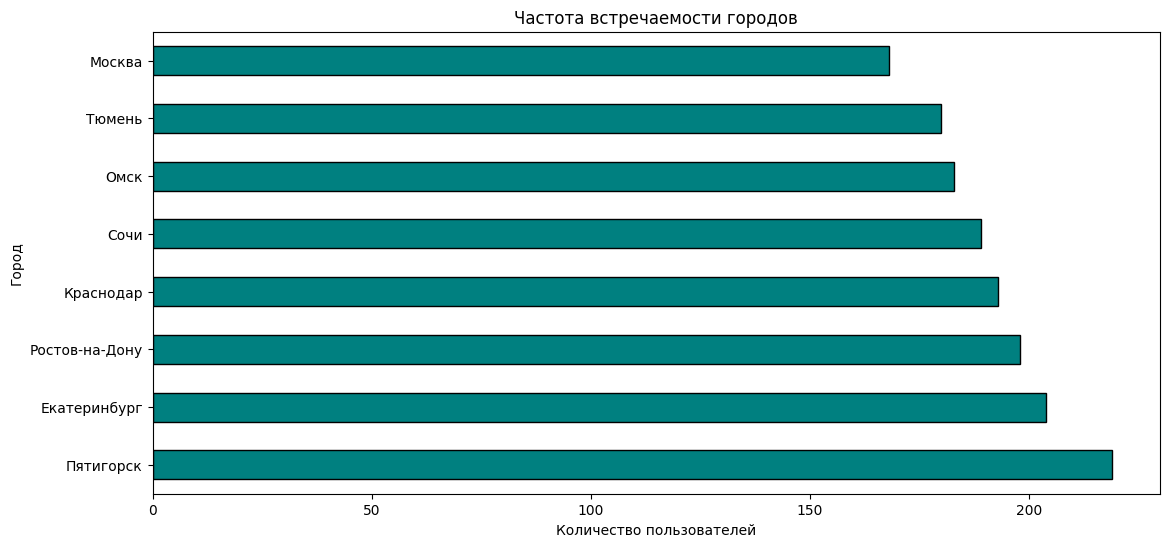

In [21]:
users.pivot_table(index='city', values='user_id', aggfunc='count').sort_values(by='user_id', 
                                                                               ascending=False).plot(kind='barh', legend=False,
                                                                                                     figsize=(13, 6), 
                                                                                                     edgecolor='black',
                                                                                                     color = 'teal')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Частота встречаемости городов')
plt.show()

**Вывод:** наиболее часто встречается город Пятигорск - 219 пользователей из данного города, меньше всего пользователей из Москвы - 168. 

#### Соотношение пользователей с подпиской и без подписки

In [22]:
users['subscription_type'].value_counts()

free     835
ultra    699
Name: subscription_type, dtype: int64

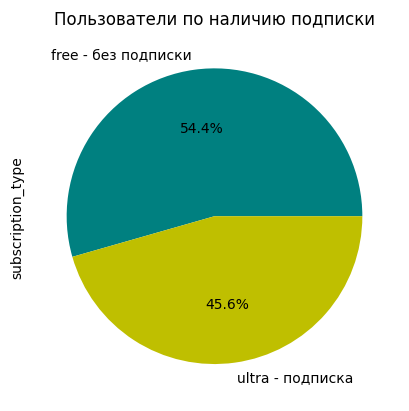

In [23]:
types = users.groupby('subscription_type')['subscription_type'].count()
types.plot(kind='pie', autopct='%1.1f%%', radius=1,
           title='Пользователи по наличию подписки', 
           colors = ['teal', 'y'], 
           labels = ['free - без подписки', 'ultra - подпискa'])
plt.show()

**Вывод:** пользователей без подписки больше (835 чел), чем пользователей с подпиской Ultra (699 чел): 54.4% против 45.6%. 

#### Возраст пользователей

In [24]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

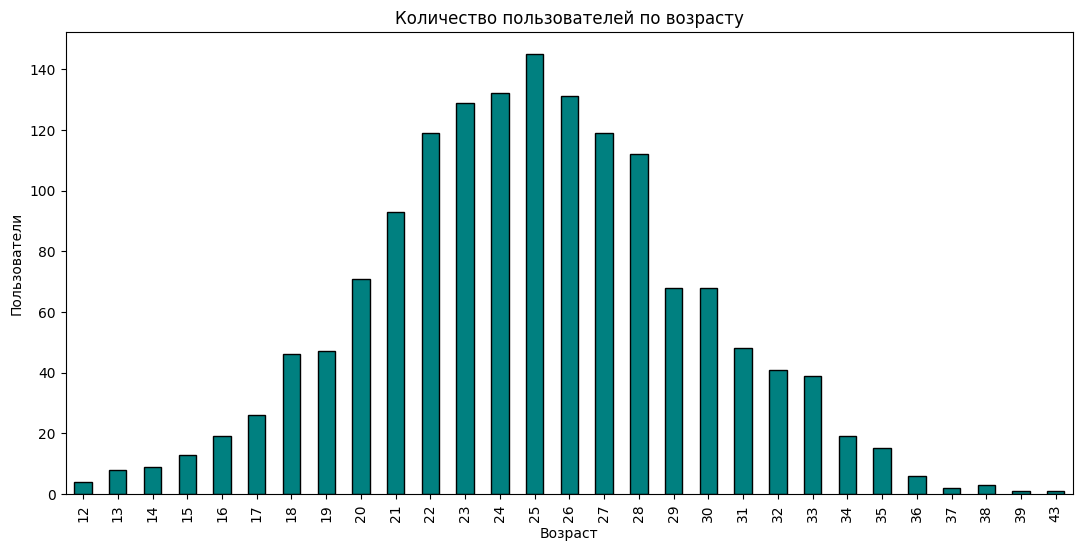

In [25]:
users.pivot_table(index='age', values='user_id', aggfunc='count').plot(kind='bar', legend=False, figsize=(13, 6), 
                                                                       edgecolor='black', color = 'teal')
plt.xlabel('Возраст')
plt.ylabel('Пользователи')
plt.title('Количество пользователей по возрасту')
plt.show()

**Вывод:** Больше всего мобильным приложением сервиса пользуются люди в возрасте от 20 до 30 лет с пиком - 25 лет, меньше всего пользователей в возрасте от 37 до 43 лет. Минимальный возраст - 12 лет, максимальный - 43 года.

#### Расстояние, которое пользователь преодолел за одну поездку

Округлим расстояние, которое преодолел пользователь в метрах за одну поездку, до двух знаков после запятой:

In [26]:
rides['distance'] = rides['distance'].round(2)
rides.head()

,user_id,distance,duration,date,month
0,1,4409.92,25.599769,2021-01-01,1
1,1,2617.59,15.816871,2021-01-18,1
2,1,754.16,6.232113,2021-04-20,4
3,1,2694.78,18.511000,2021-08-11,8
4,1,4028.69,26.265803,2021-08-28,8


In [27]:
rides['distance'].describe()

count    18068.000000
mean      3070.659992
std       1116.831222
min          0.860000
25%       2543.227500
50%       3133.610000
75%       3776.220000
max       7211.010000
Name: distance, dtype: float64

Минимальное расстояние одной поездки 0.86 м, максимальное - 7211 м, в среднем пользователь проезжает 3070 м за одну поездку, медианное расстояние - 3133 м.

Визуализируем данные:

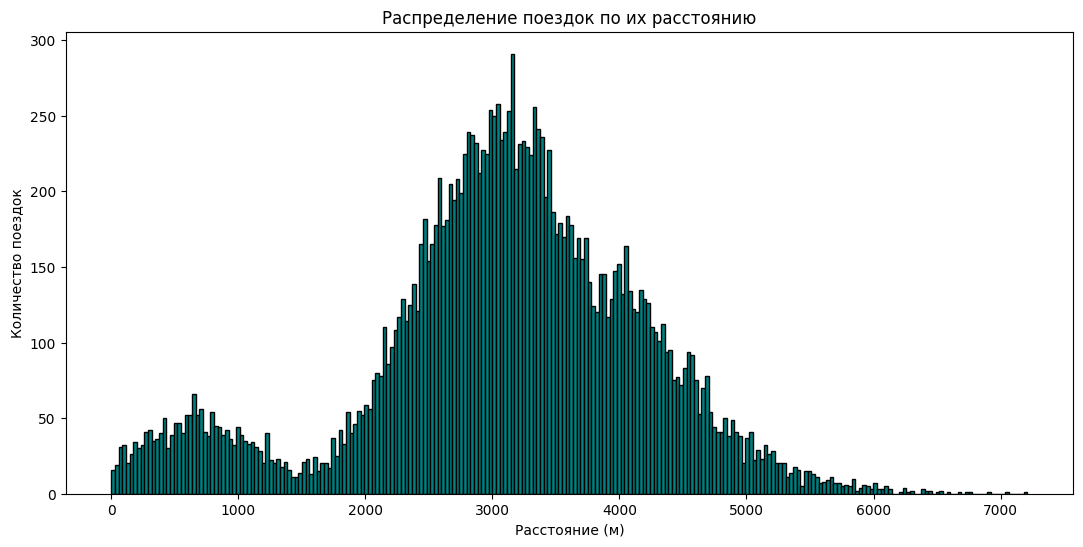

In [28]:
rides['distance'].plot(kind='hist', bins=250, figsize=(13, 6), color = 'teal', edgecolor='black')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Распределение поездок по их расстоянию')
plt.show()

**Вывод:** Наблюдаются две волны с пиками около 700 м и 3200 м. Возможно, первая волна указывает на пользователей, которые используют аренду самоката для передвижения между остановками общественного транспорта во время пересадки либо доезда от дома до остановки или обратно. Пользователи из второй волны могут использовать самокат как основное средство передвижения по городу на расстояния около 3 км. Минимальное расстояние одной поездки 0.86 м, максимальное - 7211 м, в среднем пользователь проезжает 3070 м за одну поездку, медианное расстояние - 3133 м.

#### Продолжительность поездок

Округляем время продолжительности поездки (мин) до следующего целого числа и изменим тип данных на целочисленный:

In [29]:
rides['duration'] = np.ceil(rides['duration']).astype(int)
rides.head()

,user_id,distance,duration,date,month
0,1,4409.92,26,2021-01-01,1
1,1,2617.59,16,2021-01-18,1
2,1,754.16,7,2021-04-20,4
3,1,2694.78,19,2021-08-11,8
4,1,4028.69,27,2021-08-28,8


In [30]:
rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

Минимальное время одной поездки 1 мин, максимальное - 41 мин, в среднем одна сессия длится 18 мин, медианное время так же 18 мин.

Визуализируем данные:

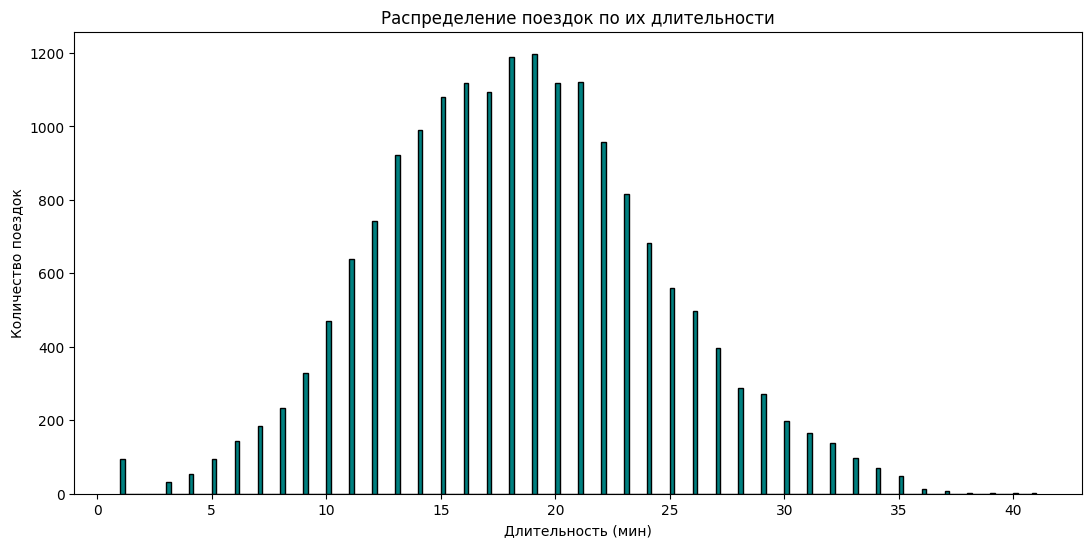

In [31]:
rides['duration'].plot(kind='hist', bins=200, figsize=(13, 6), color = 'teal', edgecolor='black')
plt.xlabel('Длительность (мин)')
plt.ylabel('Количество поездок')
plt.title('Распределение поездок по их длительности')
plt.show()

**Вывод:** больше всего поездок длительностью примерно от 10 до 27 минут с пиком 18-19 минут. Минимальное время одной поездки 1 мин, максимальное - 41 мин, в среднем одна сессия длится 18 мин, медианное время так же 18 мин.

#### Общий вывод

**При выполнении исследовательского анализа данных, было выявлено:**
1. из 8 городов, наиболее часто встречается город Пятигорск - 219 пользователей из данного города, меньше всего пользователей из Москвы - 168;
2. пользователей без подписки больше (835 чел), чем пользователей с подпиской Ultra (699 чел): 54.4% против 45.6%;
3. больше всего мобильным приложением сервиса пользуются люди в возрасте от 20 до 30 лет с пиком - 25 лет, меньше всего пользователей в возрасте от 37 до 43 лет. Минимальный возраст - 12 лет, максимальный - 43 года;
4. по расстоянию поездок наблюдаются две волны с пиками около 700 м и 3200 м. Возможно, первая волна указывает на пользователей, которые используют аренду самоката для передвижения между остановками общественного транспорта во время пересадки либо доезда от дома до остановки или обратно. Пользователи из второй волны могут использовать самокат как основное средство передвижения по городу на расстояния около 3 км. Минимальное расстояние одной поездки 0.86 м, максимальное - 7211 м, в среднем пользователь проезжает 3070 м за одну поездку, медианное расстояние - 3133 м;
5. больше всего поездок длительностью примерно от 10 до 27 минут с пиком 18-19 минут. Минимальное время одной поездки 1 мин, максимальное - 41 мин, в среднем одна сессия длится 18 мин, медианное время так же 18 мин.

### Объединение данных

#### Объединение всех данных в один датафрейм

Объединяем данные о пользователях, поездках и подписках в один датафрейм с помощью метода merge():

In [32]:
total_data = users.merge(rides, on='user_id')
total_data = total_data.merge(subscriptions, on='subscription_type')
print('Датафрейм с объединенными данными')
display(total_data.head())
print('Инфомация о датафрейме')
print()
total_data.info()

Датафрейм с объединенными данными


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


Инфомация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int32         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 1.7+ MB


Проверяем наличие дубликатов после объединения:

In [33]:
total_data.duplicated().sum()

0

Явных дубликатов не обнаружено.

In [34]:
print('Количество строк в rides:', len(rides))
print('Количество строк в total_data:', len(total_data))

Количество строк в rides: 18068
Количество строк в total_data: 18068


**Вывод:** количество значений (строк) в итоговом датафрейме (total_data) соответствует количеству в исходном датафрейме (rides), объединение прошло успешно, без наличия пропусков.

#### Исследование данных о пользователях по наличию/отсутствию подписки

Создадим еще два датафрейма из созданного выше (total_data): с данными о пользователях без подписки и с данными о пользователях с подпиской:

In [35]:
data_free = total_data.query('subscription_type == "free"')
print('Датафрейм с данными о пользователях без подписки')
display(data_free.head())
print('Инфомация о датафрейме')
print()
data_free.info()

Датафрейм с данными о пользователях без подписки


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.69,15,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.93,17,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.43,21,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.91,10,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.38,18,2021-02-14,2,8,50,0


Инфомация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  int32         
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int64         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 1.1+ MB


In [36]:
data_ultra = total_data.query('subscription_type == "ultra"')
print('Датафрейм с данными о пользователях с подпиской')
display(data_ultra.head())
print('Инфомация о датафрейме')
print()
data_ultra.info()

Датафрейм с данными о пользователях с подпиской


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27,2021-08-28,8,6,0,199


Инфомация о датафрейме

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   int32         
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int64         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 634.8+ KB


Проверка разделения данных:

In [37]:
if len(total_data) == len(data_ultra) + len(data_free):
    print('Разделение прошло успешно')
else:
    print('Разделение прошло с ошибкой')

Разделение прошло успешно


**Вывод:** созданы два датафрейма: пользователи с подпиской (data_ultra) и пользователи без подписки (data_free). Разделение прошло успешно.

#### Визуализация информации о расстоянии поездок в зависимости от наличия/отсутствия подписки

In [38]:
print('Характеристики расстояния поездок с подпиской Ultra')
data_ultra['distance'].describe()

Характеристики расстояния поездок с подпиской Ultra


count    6500.000000
mean     3115.445431
std       836.895369
min       244.210000
25%      2785.447500
50%      3148.640000
75%      3560.577500
max      5699.770000
Name: distance, dtype: float64

**Вывод:** минимальное расстояние поездки 244 м, максимальное - 5699 м. В среднем пользователи проезжают 3155 м, медианное расстояние - 3148 м. Общее количество поездок с подпиской Ultra - 6500.

In [39]:
print('Характеристики расстояния поездок без подписки (free)')
data_free['distance'].describe()

Характеристики расстояния поездок без подписки (free)


count    11568.000000
mean      3045.495284
std       1246.173810
min          0.860000
25%       2366.560000
50%       3114.650000
75%       3905.695000
max       7211.010000
Name: distance, dtype: float64

**Вывод:** минимальное расстояние поездки 0.86 м, максимальное - 7211 м. В среднем пользователи проезжают 3045 м, медианное расстояние - 3114 м. Общее количество поездок без подписки (free) - 11568.

Сравним расстояния поездок в зависимости от наличия/отсутствия подписки при помощи гистограммы:

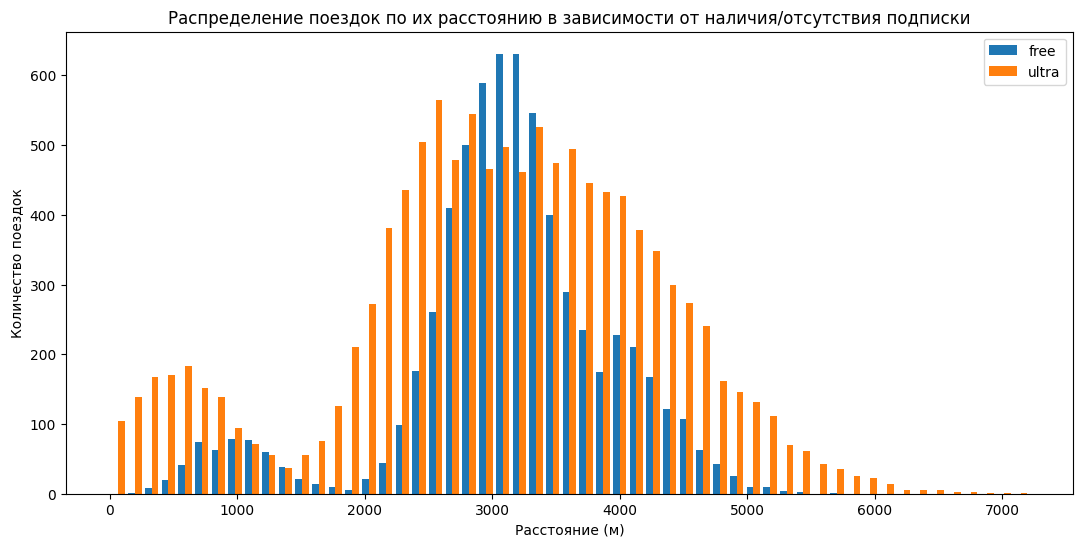

In [40]:
plt.hist([data_ultra['distance'], data_free['distance']], bins=55, label=['free', 'ultra'])
plt.gcf().set_size_inches(13, 6)
plt.legend(loc='upper right')
plt.xlabel('Расстояние (м)')
plt.ylabel('Количество поездок')
plt.title('Распределение поездок по их расстоянию в зависимости от наличия/отсутствия подписки')
plt.show()

**Вывод:** расстояние поездок пользователей без подписки имеют более широкий разброс. В обеих категориях заметно два пика. 

Пользователи с подпиской Ultra: минимальное расстояние поездки 244 м, максимальное - 5699 м. В среднем пользователи проезжают 3155 м, медианное расстояние - 3148 м. Общее количество поездок - 6500.

Пользователи без подписки free: минимальное расстояние поездки 0.86 м, максимальное - 7211 м. В среднем пользователи проезжают 3045 м, медианное расстояние - 3114 м. Общее количество поездок - 11568.

#### Визуализация информации о времени поездок в зависимости от наличия/отсутствия подписки

In [41]:
print('Характеристики времени поездок с подпиской Ultra')
data_ultra['duration'].describe()

Характеристики времени поездок с подпиской Ultra


count    6500.000000
mean       19.037692
std         5.577439
min         4.000000
25%        15.000000
50%        19.000000
75%        22.000000
max        41.000000
Name: duration, dtype: float64

**Вывод:** минимальное время поездки 4 мин, максимальное - 41 мин. В среднем поездка длится 19 мин, медианное время - 19 м. Общее количество поездок с подпиской Ultra - 6500.

In [42]:
print('Характеристики времени поездок без подписки (free)')
data_free['duration'].describe()

Характеристики времени поездок без подписки (free)


count    11568.000000
mean        17.890992
std          6.330250
min          1.000000
25%         13.000000
50%         18.000000
75%         22.000000
max         35.000000
Name: duration, dtype: float64

**Вывод:** минимальное время поездки 1 мин, максимальное - 35 мин. В среднем поездка длится почти 18 мин, медианное время - 18 мин. Общее количество поездок без подписки (free) - 11568.

Сравним время поездок в зависимости от наличия/отсутствия подписки при помощи гистограммы:

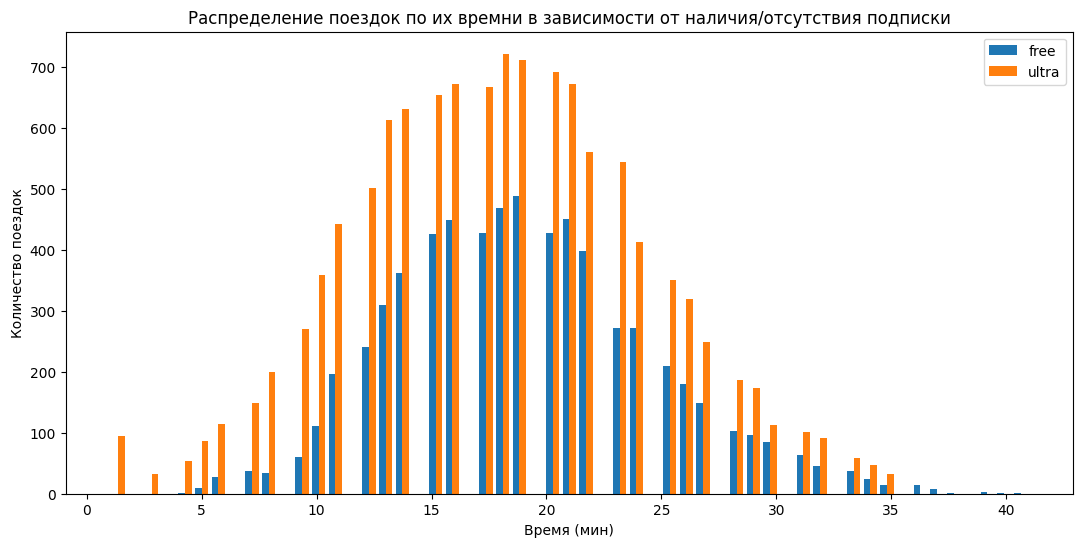

In [43]:
plt.hist([data_ultra['duration'], data_free['duration']], bins=55, label=['free', 'ultra'])
plt.gcf().set_size_inches(13, 6)
plt.legend(loc='upper right')
plt.xlabel('Время (мин)')
plt.ylabel('Количество поездок')
plt.title('Распределение поездок по их времни в зависимости от наличия/отсутствия подписки')
plt.show()

**Вывод:** длительность поездок распределена практически равномерно между категориями.

Пользователи с подпиской Ultra: минимальное время поездки 4 мин, максимальное - 41 мин. В среднем поездка длится 19 мин, медианное время - 19 м. Общее количество поездок - 6500.

Пользователи без подписки free: минимальное время поездки 1 мин, максимальное - 35 мин. В среднем поездка длится почти 18 мин, медианное время - 18 мин. Общее количество поездок - 11568.

#### Общий вывод

Объединены данные о пользователях, поездках и подписках в один датафрейм. Созданы новые два датафрейма: пользователи с подпиской и пользователи без подписки (разделение данных в зависимости от подписки).

Проведен анализ пользователей сервиса на основе наличия/отсутсвия платной подписки:

1. Расстояние: 
- пользователи с подпиской Ultra: минимальное расстояние поездки 244 м, максимальное - 5699 м. В среднем пользователи проезжают 3155 м, медианное расстояние - 3148 м. Общее количество поездок - 6500;
- пользователи без подписки free: минимальное расстояние поездки 0.86 м, максимальное - 7211 м. В среднем пользователи проезжают 3045 м, медианное расстояние - 3114 м. Общее количество поездок - 11568.
2. Длительность:
- пользователи с подпиской Ultra: минимальное время поездки 4 мин, максимальное - 41 мин. В среднем поездка длится 19 мин, медианное время - 19 м. Общее количество поездок - 6500;
- пользователи без подписки free: минимальное время поездки 1 мин, максимальное - 35 мин. В среднем поездка длится почти 18 мин, медианное время - 18 мин. Общее количество поездок - 11568.

### Подсчёт выручки

#### Расчет помесячной выручки каждого пользователя

Создаем датафрейм с агрегированными данными о поездках (revenue_data) на основе датафрейма с объединенными данными (total_data), где для каждого пользователя за каждый месяц рассчитаны:

- distance_count - количество поездок;
- distance_sum - суммарное расстояние поездок;
- duration_sum - суммарное время поездок;
- minute_price - стоимость одной минуты поездке в зависимости от подписки;
- start_ride_price - стоимость начала поездки;
- subscription_fee - стоимость ежемесячного платежа.

In [44]:
revenue_data = total_data.pivot_table(index=('user_id', 'month'), 
                                 values=('distance', 'duration', 'minute_price', 'start_ride_price', 'subscription_fee'), 
                                 aggfunc=({'distance':{'count', 'sum'}, 'duration':'sum', 'minute_price': 'mean',
                                           'start_ride_price':'mean','subscription_fee':'mean',}))

revenue_data.columns = ['distance_count', 'distance_sum', 'duration_sum', 'minute_price', 
                   'start_ride_price', 'subscription_fee']
revenue_data.head(15)

distance_count  distance_sum  duration_sum  minute_price  \
user_id month                                                             
1       1                   2       7027.51            42             6   
        4                   1        754.16             7             6   
        8                   2       6723.47            46             6   
        10                  2       5809.91            32             6   
        11                  3       7003.50            56             6   
        12                  2       6751.63            28             6   
2       3                   3      10187.73            63             6   
        4                   2       6164.39            40             6   
        6                   1       3255.34            14             6   
        7                   2       6780.73            48             6   
        8                   1        923.01             7             6   
        10                  1       2824.64            19             6   
        12                  1       3828.25            12             6   
3       1                   1       3061.78            13             6   
        2                   2       5421.16            39             6   

               start_ride_price  subscription_fee  
user_id month                                      
1       1                     0               199  
        4                     0               199  
        8                     0               199  
        10                    0               199  
        11                    0               199  
        12                    0               199  
2       3                     0               199  
        4                     0               199  
        6                     0               199  
        7                     0               199  
        8                     0               199  
        10                    0               199  
        12                    0               199  
3       1                     0               199  
        2                     0               199

Посчитаем помесячную выручку, которую принес каждый пользователь сервису, результат добавим в датафрейм в столбец 'revenue_month':

In [45]:
revenue_data['revenue_month'] = ((revenue_data['start_ride_price'] * revenue_data['distance_count']) + 
                                 (revenue_data['minute_price'] * revenue_data['duration_sum']) + 
                                 revenue_data['subscription_fee'])
revenue_data.head(10)

distance_count  distance_sum  duration_sum  minute_price  \
user_id month                                                             
1       1                   2       7027.51            42             6   
        4                   1        754.16             7             6   
        8                   2       6723.47            46             6   
        10                  2       5809.91            32             6   
        11                  3       7003.50            56             6   
        12                  2       6751.63            28             6   
2       3                   3      10187.73            63             6   
        4                   2       6164.39            40             6   
        6                   1       3255.34            14             6   
        7                   2       6780.73            48             6   

               start_ride_price  subscription_fee  revenue_month  
user_id month                                                     
1       1                     0               199            451  
        4                     0               199            241  
        8                     0               199            475  
        10                    0               199            391  
        11                    0               199            535  
        12                    0               199            367  
2       3                     0               199            577  
        4                     0               199            439  
        6                     0               199            283  
        7                     0               199            487

In [46]:
print('Характеристики пользователей без подписки')
display(revenue_data.query('subscription_fee == 0').describe())
print('Характеристики пользователей с подпиской')
display(revenue_data.query('subscription_fee > 0').describe())

Характеристики пользователей без подписки


,distance_count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,revenue_month
count,6798.000000,6798.000000,6798.000000,6798.0,6798.0,6798.0,6798.000000
mean,1.701677,5182.449167,30.444690,8.0,50.0,0.0,328.641365
std,0.894871,3198.989398,17.876362,0.0,0.0,0.0,183.868330
min,1.000000,2.570000,1.000000,8.0,50.0,0.0,58.000000
25%,1.000000,2952.362500,18.000000,8.0,50.0,0.0,194.000000
50%,1.000000,4324.635000,26.000000,8.0,50.0,0.0,274.000000
75%,2.000000,6861.657500,40.000000,8.0,50.0,0.0,428.000000
max,7.000000,23429.490000,143.000000,8.0,50.0,0.0,1444.000000


Характеристики пользователей с подпиской


,distance_count,distance_sum,duration_sum,minute_price,start_ride_price,subscription_fee,revenue_month
count,4533.000000,4533.000000,4533.000000,4533.0,4533.0,4533.0,4533.000000
mean,1.433929,4467.327443,27.298698,6.0,0.0,199.0,362.792191
std,0.696331,2353.168364,14.710456,0.0,0.0,0.0,88.262737
min,1.000000,244.210000,4.000000,6.0,0.0,199.0,223.000000
25%,1.000000,2981.760000,17.000000,6.0,0.0,199.0,301.000000
50%,1.000000,3572.520000,23.000000,6.0,0.0,199.0,337.000000
75%,2.000000,5883.370000,35.000000,6.0,0.0,199.0,409.000000
max,6.000000,20009.710000,126.000000,6.0,0.0,199.0,955.000000


**Вывод:** 

Пользователи с подпиской: минимальный чек - 223 руб, средний - 363 руб, медиана - 337 руб, максимальный - 955 руб.

Пользователи без подписки: минимальный чек - 58 руб, средний - 328 руб, медиана - 274 руб, максимальный - 1444 руб.

Пользователи с подпиской выгодней для сервиса, чем пользователи без подписки.

#### Общий вывод

Создан датафрейм с агрегированными данными о поездках. Рассчитана помесячная выручка, которую принес каждый пользователь сервису. Пользователи с подпиской оказались выгодней для сервиса, они приносят большую выручку, чем пользователи без подписки.

### Проверка гипотез

Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции, но сначала нужно выяснить:

- тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании;
- расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?;
- будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?.

#### Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Важно понять, тратят ли пользователи с подпиской больше времени на поездки, чем пользователи без подписки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим эту гипотезу. 

**Нулевая гипотеза Н0:** среднее время продолжительности поездки пользователей с подпиской (Ultra) равно среднему времени продолжительности поездки пользователей без подписки (free);

**Альтернативная гипотеза Н1:** среднее время продолжительности поездки пользователей с подпиской (Ultra) больше среднего времени продолжительности поездки пользователей без подписки (free).

In [47]:
# data_free['duration'] - время продолжительности поездок пользователей без подписки
# data_ultra['duration'] - время продолжительности поездок пользователей с подпиской

alpha = 0.05 # обозначим уровень значимости 5%

results = st.ttest_ind(data_ultra['duration'], data_free['duration'], alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 2.495945372073663e-34
Отвергаем нулевую гипотезу


**Вывод:** Нулевая гипотеза отвергнута в пользу альтернативной. Следовательно, делаем вывод, что пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки. Таким образом, пользователи с подпиской для сервиса выгодней. Уровень значимости обозначен в 5%.

#### Гипотеза 2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м.

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим гипотезу.

**Нулевая гипотеза Н0:** среднее расстояние, которое проезжают пользователи с подпиской (Ultra) за одну поездку равно оптимальному расстоянию с точки зрения износа самоката;

**Альтернативная гипотеза Н1:** среднее расстояние, которое проезжают пользователи с подпиской (Ultra) за одну поездку больше оптимального расстояния с точки зрения износа самоката.

In [48]:
# data_ultra['distance'] - продолжительность поездок пользователей с подпиской

optimal_distance = 3130

alpha = 0.05

results = st.ttest_1samp(data_ultra['distance'], optimal_distance, alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 0.9195362605842414
Нет оснований отвергать нулевую гипотезу


**Вывод:** Нет оснований отвергать нулевую гипотезу в пользу альтернативной. Следовательно, делаем вывод, что пользователи с подпиской проезжают расстояние, не превышающее оптимальное 3130 метров. Уровень значимости обозначен в 5%.

#### Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Проверим гипотезу о том, что помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

**Нулевая гипотеза Н0:** помесячная выручка от пользователей с подпиской (Ultra) по месяцам равна помесячной выручке от пользователей без подписки (free);

**Альтернативная гипотеза Н1:** помесячная выручка от пользователей с подпиской (Ultra) по месяцам больше помесячной выручки от пользователей без подписки (free).

In [49]:
# revenue_data['subscription_fee'] > 0 - пользователи с подпиской (ежемесячная абонентская плата есть)
# revenue_data['subscription_fee'] == 0 - пользователи без подписки (ежемесячной абонентской платы нет)

alpha = 0.05 # обозначим уровень значимости 5%

results = st.ttest_ind(revenue_data.loc[revenue_data['subscription_fee'] > 0, 'revenue_month'], 
                       revenue_data.loc[revenue_data['subscription_fee'] == 0, 'revenue_month'], 
                       alternative='greater')

print(f'p-value: {results.pvalue}')

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу


**Вывод:** Нулевая гипотеза отвергнута в пользу альтернативной. Следовательно, делаем вывод, что помесячная выручка от пользователей с подпиской больше, чем выручка от пользователей без подписки. Таким образом, пользователи с подпиской для сервиса выгодней. Уровень значимости обозначен в 5%.

#### Анализ ситуации и вариант проверки гипотезы

**Ситуация:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест понадобился бы для проверки этой гипотезы?

**Вариант проверки гипотезы:** данные о количестве обращений до обновления и после него - это две зависимые (парные) выборки, проверяется гипотеза о равенстве среднего значения генеральной совокупности до и после изменений. Главное условие - одинаковый размер выборок до и после. 

Нужный метод для проверки: scipy.stats.ttest_rel().
В качестве аргументов: парные выборки до и после изменений.

**Для вышеуказанной ситуации при условии одинакового размера выборок:**

H0: количество обращений до обновления (before_appeals) равно количеству обращений после обновления (after_appeals);

H1: количество обращений до обновления (before_appeals) больше количества обращений после обновления (after_appeals).

results = st.ttest_rel(before_appeals, after_appeals, alternative = 'greater').

**Если условия к зависимым выборкам не выполняются, то нужный тест для проверки гипотезы:**

results = st.ttest_ind(before_appeals, after_appeals, alternative = 'greater').

#### Общий вывод

Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки - не опровергнута.

Гипотеза 2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м - не опровергнута.

Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки - не опровергнута.

### Распределения

**Задание:** отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 
10 % пользователей. Какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 
5 %?  Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

**Решение:** т.к 10% пользователей продлевают подписку после бесплатного пробного периода, то при необходимом количестве - 100 новых клиентов - нужно раздать минимум 1000 промокодов. Примем n = 1000 при вероятности успеха p = 0.1 (10%), построим график распределения.
Укажем число благоприятных исходов k равным 99 и вероятность не выполнить план p2 = 0.05 (5%).

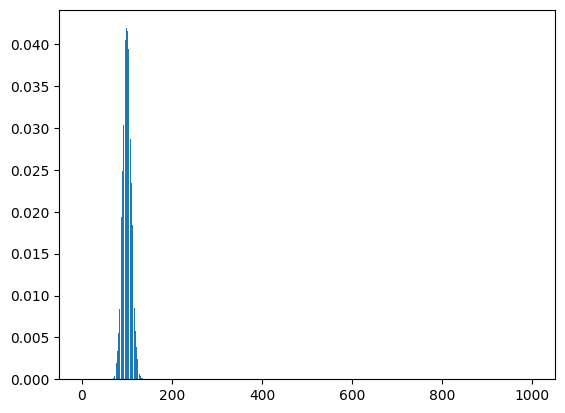

Минимальное количество промокодов - 1161 нужно разослать, чтобы вероятность не выполнить план была около 5.0 %.


In [50]:
n = 1000
p = 0.1
distr = []
for k in range(0, n + 1):
    choose = factorial(n) / (factorial(k) * factorial(n - k))
    prob = choose * p**k * (1 - p)**(n - k)
    distr.append(prob)
plt.bar(range(0, n + 1), distr)
plt.show()

k = 99
p2 = 0.05
while p2 < binom.cdf(k, n, p):
    n += 1
print(f'Минимальное количество промокодов - {n} нужно разослать, чтобы вероятность не выполнить план была около {binom.cdf(k, n, p).round(2) * 100} %.')

**Вывод:** нужно разослать как минимум 1161 промокод, чтобы как минимум 100 пользователей продлили подписку при условии, что продлевают подписку 10% пользователей, получивших промокод - с вероятностью не выполнить план в 5%.

**Задание:** Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. С помощью аппроксимации оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

**Решение:** ситуация описывается биноминальным распределением. Воспользуемся нормальной аппроксимацией биноминального распределения и посчитаем вероятность того, что уведомление откроют не более 399500 пользователей. 

In [51]:
n = 1000000
p = 0.4
x = 399500

mu = n * p
sigma = sqrt(n * p  * (1 - p))

distr = st.norm(mu, sigma)
result = distr.cdf(x)
print(result)
print(f'Вероятность того, что уведомление откроют не более {x} пользователей, равна около {result.round(3) * 100} %.')

0.15371708296369768
Вероятность того, что уведомление откроют не более 399500 пользователей, равна около 15.4 %.


**Вывод:** при рассылке 1 млн push-уведомлений вероятность того, что это уведомление откроют не более 399500 пользователей, равна около 15.4 %, это при условии, что открывают 40% пользователей.

### Общий вывод исследования

**При выполнении предобработки данных проведены:**

1. Проверка корректной записи названий столбцов. Ошибок не выявлено.

2. Проверка наличия дубликатов. Явные дубликаты были обнаружены в датафрейме 'users' (данные о пользователях) - удалены.

3. Проверка наличия пропущенных значений. Пропусков не выявлено.

4. Изменение типов данных. Тип данных в столбце 'date' датафрейма rides изменен с object на datetime.

5. Создание новых колонок. В датафрейм rides добавлен столбец 'month' с номером месяца (1 - январь, 2 - февраль и тд.).

**При выполнении исследовательского анализа данных, было выявлено:**
1. из 8 городов, наиболее часто встречается город Пятигорск - 219 пользователей из данного города, меньше всего пользователей из Москвы - 168;
2. пользователей без подписки больше (835 чел), чем пользователей с подпиской Ultra (699 чел): 54.4% против 45.6%;
3. больше всего мобильным приложением сервиса пользуются люди в возрасте от 20 до 30 лет с пиком - 25 лет, меньше всего пользователей в возрасте от 37 до 43 лет. Минимальный возраст - 12 лет, максимальный - 43 года;
4. по расстоянию поездок наблюдаются две волны с пиками около 700 м и 3200 м. Возможно, первая волна указывает на пользователей, которые используют аренду самоката для передвижения между остановками общественного транспорта во время пересадки либо доезда от дома до остановки или обратно. Пользователи из второй волны могут использовать самокат как основное средство передвижения по городу на расстояния около 3 км. Минимальное расстояние одной поездки 0.86 м, максимальное - 7211 м, в среднем пользователь проезжает 3070 м за одну поездку, медианное расстояние - 3133 м;
5. больше всего поездок длительностью примерно от 10 до 27 минут с пиком 18-19 минут. Минимальное время одной поездки 1 мин, максимальное - 41 мин, в среднем одна сессия длится 18 мин, медианное время так же 18 мин.

**Объединение данных, было выполнено:**

Объединены данные о пользователях, поездках и подписках в один датафрейм. Созданы новые два датафрейма: пользователи с подпиской и пользователи без подписки (разделение данных в зависимости от подписки).

Проведен анализ пользователей сервиса на основе наличия/отсутсвия платной подписки:

1. Расстояние: 
- пользователи с подпиской Ultra: минимальное расстояние поездки 244 м, максимальное - 5699 м. В среднем пользователи проезжают 3155 м, медианное расстояние - 3148 м. Общее количество поездок - 6500;
- пользователи без подписки free: минимальное расстояние поездки 0.86 м, максимальное - 7211 м. В среднем пользователи проезжают 3045 м, медианное расстояние - 3114 м. Общее количество поездок - 11568.
2. Длительность:
- пользователи с подпиской Ultra: минимальное время поездки 4 мин, максимальное - 41 мин. В среднем поездка длится 19 мин, медианное время - 19 м. Общее количество поездок - 6500;
- пользователи без подписки free: минимальное время поездки 1 мин, максимальное - 35 мин. В среднем поездка длится почти 18 мин, медианное время - 18 мин. Общее количество поездок - 11568.

**Подсчет выручки, было выполнено:**

Создан датафрейм с агрегированными данными о поездках. Рассчитана помесячная выручка, которую принес каждый пользователь сервису. Пользователи с подпиской оказались выгодней для сервиса, они приносят большую выручку, чем пользователи без подписки.


**Проверка гипотез:**

Гипотеза 1. Пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки - не опровергнута.

Гипотеза 2. Расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 м - не опровергнута.

Гипотеза 3. Помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки - не опровергнута.